In [2]:
'''
Ho to Start local Mongo instance 

* Download mongo database dump: https://docs.google.com/document/d/1NtpGGV8vr52iIrDuogOShAAUUcyrI452s7oX4SPpYCo/edit?usp=sharing

* Check if Mongo is running: 
$ ps -ef | grep mongod

* Start MongoD on local machine: 
$sudo brew services start mongodb-community@3.4

* Load the dump
mongorestore --host localhost:27017 --authenticationDatabase admin --db job_db --collection ServicebusCreateMessage [full path here]/ServicebusCreateMessage.bson

'''


## MATH
import numpy as np
import pandas as pd
import collections
from collections import Counter
from collections import defaultdict

import networkx as nx

from sklearn.decomposition import NMF

### NLP
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
# nltk.download("stopwords")
import warnings 

import gensim
from gensim.models import Word2Vec 

import ngram

## GRAPHICS & PRESENTATION
import seaborn as sns
from matplotlib import pyplot as plt

import pprint

## DATA MANAGEMENT + I/O
import json
from json import dumps
from bson import ObjectId
from bs4 import BeautifulSoup

import neo4j
from neo4j import GraphDatabase

from pymongo import MongoClient
import bson.json_util as bj

## OS
import os
import urllib
import requests

client = MongoClient('mongodb://localhost:27017/')
#Getting a database
db = client['job_db']
#getting a collection
collection = db['ServicebusCreateMessage']

# Test - select one message
test = collection.find_one()

# Assign the whole DB to a variable
whole_db = collection.find()
# Search the variable:
# look at first record:
whole_db[1]
# Do a search
whole_db[2]['Message']['Company'],whole_db[2]['Model']['Title']
# output: ('Manpower', 'customer service representative')


## Dump db as a series of json files:
#
# def write_json(start_record,end_record):
#     whole_db = collection.find()[:]
#     f = open('job_db_'+str(start_record)+'_'+str(end_record)+'.json','w+')
#     f.write(bj.dumps(whole_db[start_record:end_record]))
#     f.close()
#     return
#
# for i in range(2,15):
#     write_json((i-1)*100000, i*100000 - 1)

class JobDescriptions:
    def __init__(self,                                         \
                 db         = 'job_db',                        \
                 client     = 'mongodb://localhost:27017/',    \
                 collection = 'ServicebusCreateMessage'):
        
        self.client     = MongoClient(client)
        self.db         = self.client[db]
        self.collection = self.db[collection]
        
        # Function Caches
        self.get_dic                    = {}
        self.duplicates_dic             = {}
        self.get_without_duplicates_dic = {}


    def get(self,string, max_items = 50000 , display_result = True, remove_duplicates = True):
        '''
        1. Gathers job descriptions in MongoDB "collection" for jobs with the sub-string 'string' in the job title. 
                Speeds up by indexing 'collection' on job titles if index does not already exist 
                - THIS TAKES TIME, but does only need to be done once for a collection.
        2. Parses gathered job descriptions into dictionaries

        Returns Pandas Dataframe with columns = [ObjectId, 
                                                time stamp, 
                                                title, 
                                                company,
                                                description,
                                                clean description, (no formatting)
                                                length, (#characters in clean description )
                                                parsed description,
                                                corpus]
        '''
        # Check if result already in dictionary
        params = str({'string':string,'max_items':max_items})
        if params not in self.get_dic:
            collection = self.collection
            
            # Gather records with "string" in job title
            collection.create_index('Message.Title') 
            cursor = collection.find({'Message.Title':{'$regex':"(?i).*"+string+".*"}})
            cursor.limit(max_items)
            gather_list = []
            while cursor.alive:
                db_item = cursor.next()
                titl    = db_item.get('Message',{'Title':'N/A'}).get('Title').lower()
                comp    = db_item.get('Message',{'Company':'N/A'}).get('Company')
                id_nr   = db_item.get('_id')        # ObjectId().generation_time contains time stamp
                time    = id_nr.generation_time
                msg     = db_item.get('Message',{'Description':'N/A'}).get('Description')
                msg2    = db_item.get('Model',{'Description':'N/A'}).get('Description')
                length  = len(msg2)
                gather_list.append([id_nr,time,length,titl,comp,msg,msg2])

            # Convert 'gather_list' (above) to DataFrame     
            #   Column labels matching variables in gather_list 
            df_columns  = ['ObjectId','time stamp','length', 'title',\
                           'company','description','clean description']            
            df          = pd.DataFrame(gather_list, columns = df_columns )
            # Parse job descriptions
            df['parsed description']    = df['description'].apply(parse_job_description)
            df['corpus']                = df['clean description'].apply(lambda x: x.split()).apply(set)
            df['title set']             = df['title'].apply(lambda x: x.replace(',',' ').split()).apply(set)
            
            # Save result in dictionary
            self.get_dic[params] = df
        
        # Identify Duplicates
        if params not in self.duplicates_dic:
            # Group by company 
            grp_co = df[['length','ObjectId','company','corpus']].groupby('company').agg(lambda x: list(x))
            grp_co['nr of posts'] = grp_co['length'].apply(len) 

            # Select companies with THREE or more job postings
            # ********* TODO ******** : REMOVE DUPLICATES FOR COMPANIES sith TWO POSTINGS.
            companies = grp_co[grp_co['nr of posts'] > 2]
            # Identify duplicate job descriptions, selected by corpus-similarity between descriptions of similar lengths 
            # Save their ObjectId's in a dict
            dupes_dic = {}
            for company in companies.index:
                company_df         = pd.DataFrame(companies.loc[company].to_dict()).sort_values(by='length',ascending = False)
                dupes_dic[company] = dupes(company_df)['ObjectId'].values

            # Save the dict with company names and ObjectIds for dupes 
            self.duplicates_dic[params] = dupes_dic

        # RETURN:  
        # a. Return without displaying result
        if not display_result:    
            return

        # b. Return without duplicates
        if remove_duplicates:
            if params not in self.get_without_duplicates_dic:
                # Make a list of all duplicates for all companies
                all_dupes = np.concatenate(list(self.duplicates_dic[params].values()))
                # Remove duplicates
                self.get_without_duplicates_dic[params] = self.get_dic[params].set_index('ObjectId').drop(all_dupes).reset_index()
            return self.get_without_duplicates_dic[params]
        # c. Return All 
        return self.get_dic[params] 
    
    def titles(self,                              \
                title          ='program manager', \
                root           ='manager',         \
                direction      ='longer' ,         \
                **kwargs
                   ):
        df        = self.get(root,**kwargs)
        title_set = set((root+' '+title).split())
        if direction == 'longer':
            return df[(title_set - df['title set']).apply(len) == 0]
        if direction == 'shorter':
            return df[(df['title set'] - title_set).apply(len) == 0]
        
def titles_count(df,title_string='manager'):

    def listem(nn):
        return df['title'].apply(lambda x: ngrams(x,N = nn, string_form = 'words')).apply(lambda array: list(filter(lambda string: title_string in string, array)))

    def countem():
        cnt = Counter()
        [cnt.update(np.concatenate(listem(i).values)) for i in range(2,7)]
        return cnt.most_common()

    df_titles_all     = pd.DataFrame(countem(), columns = ['title','count'])
    df_titles_manager = df_titles_all[df_titles_all['title'].apply(lambda titles: titles[-len(title_string):] == title_string)]
    df_titles         = df_titles_manager.copy()[df_titles_manager['count']>1]
    df_titles['corpus'] = df_titles['title'].apply(lambda x: set(x.split()))
    df_titles['corpus length'] = df_titles['corpus'].apply(len)
    return df_titles


        

def parse_job_description(string):
    '''
    Converts description to dictionary
    1. Splits the job description into a list:  split at linebreak and html tags for bullet/paragraph
    2. Lines beginning with "*" are assigned as bullets
    3. Lines ending with ":" are assigned as keys 
    4. All other lines are added to key "000"

    (Developer's comment: Preliminary version. To be done more elegantly with RexEx)
    '''
    # Split job description into items
    split_string = string.replace('<li>','\n *'). \
                            replace('</li>','\n').\
                            replace('<p>','\n').  \
                            replace('</p>','\n'). \
                            split('\n')
    # Initiate dictionary
    key = '000'
    dic = {}
    dic['000']= []

    # Sort items into dictionary
    for item in split_string:
        item  = item.lower()
        item0 = item.replace(' ','')
        if item0 == '':
            pass
        elif item0[0] is "*":
            dic[key].append(item[1:])
        elif item0[-1] == ':':
            key = item[:-2] 
            dic[key] =[]
        else:
            dic['000'].append(item)
    return dic

def dupes(df, thresh = 0.8):
    crps = pd.DataFrame(crpsim_previous(df['corpus']),index = df.index)
    return df[crps[0] > thresh]

def crpsim_previous(corpora):
    return [0] +[corpus_similarity(pair) for pair in consecutive_pairs(corpora)] 

def corpus_similarity(corps):
    '''
    Measures similarity between two corpuses (type:set)
    '''
    corp1,corp2 = corps
    diff = len(corp1.symmetric_difference(corp2))
    total= len(corp1)+len(corp2)
    return 1- diff/total
crpsim = corpus_similarity

def consecutive_pairs(array):
    return np.array([array[1:],array[:-1]]).transpose()


def ngrams(array, N=2, string_form = False):
    '''
    Returns all N-element long sequences of neighboring elements. Works both for strings and lists.
    
    Examples:
    [in ]  ngrams([1,2,3,4])
    [out]  array([[1, 2],[2, 3],[3, 4]])
    
    [in ]  ngrams('one two three four', string_form = 'words')
    [out]  array(['one two', 'two three', 'three four'], dtype='<U10')
    
    [in ]  ngrams('one two three four', string_form = 'characters')
    [out]  array(['on', 'ne', 'e ', ' t', 'tw', 'wo', 'o ', ' t', 'th', 'hr', 're',
                  'ee', 'e ', ' f', 'fo', 'ou', 'ur'], dtype='<U2')
    '''
    # Split string
    if string_form:
        if type(array) is str:
            if string_form   is 'words':
                array = array.split()
            else:
                string_form = 'characters'
                array = [i for i in array]
    
    # Build N-grams
    if type(array[0]) in (list, np.ndarray):
        result = [ngrams(item,N=N) for item in array]
    else:
        array0 = np.append(np.array(array),0)
        result = np.transpose([array0[i:i-N] for i in range(N)])
    
    # Return result
    if string_form:
        spacer = {'words':' ', 'characters':''}
        result = np.array([spacer[string_form].join(item) for item in result])
    return result

# from sklearn.decomposition import NMF
# from scipy.linalg import svd
# from scipy.sparse.linalg import svds

# # # MATRIX-FACTORIZATION: DIMENSIONALITY REDUCTION & ARCHETYPING

# # ## CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# # ## Use non-zero matrix factorization for clustering
# # ## Use singular value decomposition first state for determining overall similarity


# ## GENERAL FUNCTIONS 
# ### NORMALIZATION
# #### Statistic normalization - subtract mean, scale by standard deviation
# def norm_stat(vec, weights = False):
#     '''
#     Normalizes a vector v-v.mean())/v.std() 
#     '''
#     if weights:
#         return  np.mean(abs(vec - vec.mean()))  
#     return (vec-vec.mean())/vec.std()

# #### Algebraic normalization - dot product
# def norm_dot(vec, weights = False):
#     '''
#     Normalizes a vector - dot product: v @ v = 1
#     '''
#     if weights:
#         return  np.sqrt(vec @ vec)
    
#     return vec / np.sqrt(vec @ vec)

# #### Algebraic normalization - dot product
# def norm_sum(vec, weights = False):
#     '''
#     Normalizes a vector - sum: v.sum = 1
#     '''
#     if weights:
#         return  vec.sum()
    
#     return vec / vec.sum()

# #### Scaled Normalization -
# def scale(vec, weights = False):
#     '''
#     Normalizes a vector: v.min = 0, v.max = 1
#     '''
#     stop_divide_by_zero = 0.00000001
#     if weights:
#         return (vec.max()-vec.min() + stop_divide_by_zero)
#     return (vec-vec.min())/(vec.max()-vec.min() + stop_divide_by_zero)

# class Archetypes:
#     '''
#     Archetypes: Performs NMF of order n on X and stores the result as attributes. 
#     Archetypes are normalized: cosine similarity a(i) @ a(i) = 1. 
#     Atributes:
#         my_archetypes.n         - order / number of archetypes
#         my_archetypes.X         - input matrix
        
#         my_archetypes.model     - NMF model 
#         my_archetypes.w         - NMF w-matrix 
#         my_archetypes.h         - NMF h-matrix
        
#         my_archetypes.o         - occupations x archetypes matrix (from w-matrix)
#         my_archetypes.on        - occupations x normalized archetypes matrix (from w-matrix) - SOCP number as index. 
#         my_archetypes.occ       - occupations x normalized archetypes matrix - Occupation names as index
        
#         my_archetypes.f         - features x archetypes matrix (from h-matrix)
#         my_archetypes.fn        - features x normalized archetypes matrix
        
#     '''
#     def __init__(self,X,n,norm = norm_dot):
#         self.n = n
#         self.X = X
#         self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
#         self.w = self.model.fit_transform(self.X)
#         self.o = pd.DataFrame(self.w,index=self.X.index)
#         self.on = self.o.T.apply(norm).T
#         self.occ = self.on.copy()
#         self.occ['Occupations'] = self.occ.index
# #        self.occ['Occupations'] = self.occ['Occupations'].apply(onet_socp_name)
#         self.occ = self.occ.set_index('Occupations')
#         self.h = self.model.components_
#         self.f = pd.DataFrame(self.h,columns=X.columns)
#         self.fn =self.f.T.apply(norm).T
#         self.plot_occupations_dic ={}
#         self.plot_features_dic ={}

        
#     def plot_features(self,fig_scale = (1,3.5),metric='cosine', method = 'single',vertical = False): 
#         '''
#         Plot Archetypes as x and features as y. 
#         Utilizes Seaborn Clustermap, with hierarchical clustering along both axes. 
#         This clusters features and archetypes in a way that visualizes similarities and diffferences
#         between the archetypes. 
        
#         Archetypes are normalized (cosine-similarity): dot product archetype[i] @ archetype[i] = 1.
#         The plot shows intensities (= squared feature coefficients) so that the sum of intensities = 1.  
#         fig_scale: default values (x/1, y/3.5) scales the axes so that all feature labels are included in the plot.
        
#         For other hyperparameters, see seaborn.clustermap
     
#         '''
#         param = (fig_scale,metric,method,vertical)
#         if param in self.plot_features_dic.keys():
#             fig = self.plot_features_dic[param]
#             return fig.fig

#         df = np.square(self.fn)

#         if vertical:
#             fig = sns.clustermap(df.T,robust = True, z_score=1,figsize=(
#                 self.n/fig_scale[0],self.X.shape[1]/fig_scale[1]),method = method,metric = metric)        
#         else: # horizontal
#             fig = sns.clustermap(df,robust = True, z_score=0,figsize=(
#                 self.X.shape[1]/fig_scale[1],self.n/fig_scale[0]),method = method,metric = metric)        
#         self.features_plot = fig
#         return fig


#     def plot_occupations(self,fig_scale = (1,3.5),metric='cosine', method = 'single',vertical = False):
#         '''
#         Plot Archetypes as x and occupations as y. 
#         Utilizes Seaborn Clustermap, with hierarchical clustering along both axes. 
#         This clusters occupations and archetypes in a way that visualizes similarities and diffferences
#         between the archetypes. 
        
#         Occupations are normalized (cosine-similarity): dot product occupation[i] @ occupation[i] = 1.
#         The plot shows intensities (= squared feature coefficients) so that the sum of intensities = 1.  
#         fig_scale: default values (x/1, y/3.5) scales the axes so that all feature labels are included in the plot.
        
#         For other hyperparameters, see seaborn.clustermap
     
#         '''
#         param = (fig_scale,metric,method,vertical)
#         if param in self.plot_occupations_dic.keys():
#             fig = self.plot_occupations_dic[param]
#             #return
#             return fig.fig

#         df = np.square(self.occ)
#         if vertical:
#             fig = sns.clustermap(df, figsize=(
#                 self.n/fig_scale[0],self.X.shape[0]/fig_scale[1]),method = method,metric = metric)
#         else: # horizontal
#             fig = sns.clustermap(df.T, figsize=(
#                 self.X.shape[0]/fig_scale[1],self.n/fig_scale[0]),method = method,metric = metric)
#         self.plot_occupations_dic[param] = fig
#         #return
#         return fig.fig


# class Svd:
#     ''''
#     Singular value decomposition-as-an-object
#         my_svd = Svd(X) returns
#         my_svd.u/.s/.vt – U S and VT from the Singular Value Decomposition (see manual)
#         my_svd.f        – Pandas.DataFrame: f=original features x svd_features
#         my_svd.o        - Pandas.DataFrame: o=occupations x svd_features
#         my_svd.volume(keep_volume) 
#                         - collections.namedtuple ('dotted dicionary'): 
#                           Dimensionality reduction. keeps 'keep_volume' of total variance
                          
                          
#     '''
#     def __init__(self,X, sparse = False):
#         if sparse:
#             sv = svds
#         else: 
#             sv = svd
            
#         self.u,self.s,self.vt = svd(np.array(X))
#         self.f = pd.DataFrame(self.vt,columns=X.columns)
#         self.o = pd.DataFrame(self.u,columns=X.index)
        
#     def volume(self,keep_volume):
#         ''' 
#         Dimensionality reduction, keeps 'keep_volume' proportion of original variance
#         Type: collections.namedtuple ('dotted dictionary')
#         Examples of usage:
#         my_svd.volume(0.9).s - np.array: eigenvalues for 90% variance 
#         my_svd.volume(0.8).f - dataframe: features for 80% variance
#         my_svd.volume(0.5).o - dataframe: occupations for 50% variance      
#         '''
#         dotted_dic = collections.namedtuple('dotted_dic', 's f o')
#         a1 = self.s.cumsum()
#         a2 = a1/a1[-1]
#         n_max = np.argmin(np.square(a2 - keep_volume))
#         cut_dic = dotted_dic(s= self.s[:n_max],f= self.f.iloc[:n_max], o= self.o.iloc[:n_max])
#         return cut_dic
        


In [3]:
# def lz_dic(array, spacer = ' '):
#     '''
#     Returns LZ compression-dictionary for strings and lists. 
#     String: [in ] lz_dic('ban banana, ban banana split', spacer = '')
#             [out] Counter({  'b'  : 2,
#                              'a'  : 3,
#                              'n'  : 4,
#                              ' '  : 3,
#                              'ba' : 1,
#                              'na' : 3,
#                              'na,': 1,
#                              ' b' : 2,
#                              'an' : 1,
#                              ' ba': 1,
#                              'nan': 1,
#                              'a ' : 1,
#                              's'  : 1,
#                              'p'  : 1,
#                              'l'  : 1,
#                              'i'  : 1,
#                              't'  : 1})
                             
#     List: [in ] lz_dic(['ban', 'banana,', 'ban', 'banana', 'split'])
#           [out] Counter({' ban': 2, ' banana,': 1, ' ban banana': 1, ' split': 1})
    
#     '''
#     cnt = Counter()
#     b = ''
#     cnt.update(b)
#     for a in array:
#         b = spacer.join([b,a])
#         if b in cnt:
#             cnt.update({b})
#         else:
#             cnt.update({b})
#             b = ''
#     return cnt

# Instantiate class
jd = JobDescriptions()

# JOB DESCRIPTION DATABASE

* 1.5M active job ads
* 3-month time window
* Untapped source of info - good for knowledge graph

## DB ORIGINAL CONTENT

* Timestamp & Status
* Original ad text (formatted)
* Pre-processed text:
    - unformatted ad text
    - extracted keywords / entities / skills 

The preprocessed keywords / entities / skills are compact and general and may have involved more data in the processing, such as Onet data for occupations.  

In [4]:
whole_db[1]

{'_id': ObjectId('5cbec831f85fd67fba2c8e42'),
 'JobId': '9c6fddeed43dd9e02e1c52cd9db7fdf8',
 'IsActive': True,
 'Model': {'Title': 'customer service representative',
  'Description': 'when our customers require assistance you ll make sure they get whatever they need to feel secure with schenectady savings loan you will greet all clients with a smiling face and an attitude that declares your eagerness to serve you ll answer the phones with a smile that can be heard on the other end you ll use your charm pleasant demeanor and can do attitude to offer banking the ssl way along the way you ll help our customers manage their accounts make deposits send money to friends and family and more schenectady savings loan offers industry leading benefits that include competitive salaries company provided healthcare roth ira and k paid time off tuition assistance management development courses customer service representative job responsibilities greet all guests as they enter your assigned branch ope

## MORE INFORMATION CAN BE EXTRACTED

It is possible to extract additional useful information from the original formatted text:

* Create a taxonomy of titles. Find the most common word combinations in titles - use these as 'general titles'
    - for each job ad title, list all matching 'general titles'
* **Text-bullets are meaningful!** Parse the original formatted ad text. Simple Algorithm:
    - Split text at line-breaks
    - If line ends with ":" it's a KEY
    - If a line begins with a bullet it's an ITEM of that key. 
    - Save all other lines in a general bucket (key '000')
* Categorize the keys/bullets
    - job requirements
    - job responisibilities
    - ...can do more

### CASE: JOB TITLES CONTAINING "MANAGER"

1. Extract records with 'manager' in the title.
2. Parse the original ad text for keys / bullets

In [5]:
title_dic = {}
def title(string,**kwargs):
    '''
    Synonym for 'jd.get()'
    '''
    param = (string,str(kwargs))
    if param not in title_dic:
        title_dic[param] = jd.get(string,**kwargs)
    return title_dic[param]
        
        

# Choose an ambiguous test title

In [80]:
root = 'teacher'

## Run Analysis

In [81]:
title(root).head()

ObjectId                time stamp  length  \
0  5d8dce27ad09d29572a1f087 2019-09-27 08:53:59+00:00    4575   
1  5d3424a1ad09d29572ccb2fd 2019-07-21 08:38:57+00:00    3537   
2  5d99ad48ad09d295723a1e4b 2019-10-06 09:00:56+00:00    2694   
3  5d970ed8ad09d29572e629f5 2019-10-04 09:20:24+00:00    4836   
4  5d946af7ad09d2957266a360 2019-10-02 09:16:39+00:00    1200   

                                               title  \
0                    a&s-psy-sr. teacher (temporary)   
1                              a180 teacher, science   
2                              aba teacher assistant   
3  abe substitute teacher - intermittent special ...   
4                          am & pm latch-key teacher   

                                         company  \
0  University Of Miami Miller School Of Medicine   
1            Houston Independent School District   
2                          The May Institute Inc   
3                             State Of Minnesota   
4         Heartfelt Impressions Learning Centers   

                                         description  \
0  Current Employees:\n  \nIf you are a current S...   
1  Attachment(s):\n\n* Maintenance Team Leader - ...   
2  Our May Center Schools for Autism and Developm...   
3  Job Details\n  \nJob Class: Special Teacher-In...   
4  <p>We are seeking a part time school age teach...   

                                   clean description  \
0  current employees if you are a current staff f...   
1  attachment s maintenance team leader cf pdf po...   
2  our may center schools for autism and developm...   
3  job details job class special teacher intermit...   
4  we are seeking a part time school age teacher ...   

                                  parsed description  \
0  {'000': ['if you are a current staff, faculty ...   
1  {'000': ['position title: maintenance team lea...   
2  {'000': ['our may center schools for autism an...   
3  {'000': ['job details', 'job class: special te...   
4  {'000': ['we are seeking a part time school ag...   

                                              corpus  \
0  {children, abandonment, structured, protected,...   
1  {locksmith, inconvenience, training, solving, ...   
2  {children, training, role, implement, origin, ...   
3  {ensure, open, implement, predatory, used, nee...   
4  {children, parents, open, would, meals, follow...   

                                           title set  
0                {(temporary), teacher, a&s-psy-sr.}  
1                           {a180, teacher, science}  
2                          {aba, teacher, assistant}  
3  {intermittent, abe, teacher, -, substitute, sp...  
4                    {&, latch-key, teacher, am, pm}

#### Example of parsed job description:

In [82]:
pprint.pprint(pd.Series(title(root)['parsed description'])[1])

{'000': ['position title: maintenance team leader',
         'contract length: 12m',
         'job code: cf0815',
         'pay grade: 27',
         'flsa exemption status: ne',
         'job family  construction & facility services',
         'job summary: provides day-to-day tactical and operational leadership '
         'to a group of maintenance staff. oversees, plans, and coordinates '
         'the work within the maintenance department. establishes '
         'relationships and communication with school principals. ensures '
         'staff is properly trained to carry out their respective duties.',
         'major duties & responsibilities ',
         'list most important duties first',
         'education: some college',
         'work experience: 3 to 5 years',
         'type of skill and/or required licensing/certification: sap, '
         'microsoft office office equipment (e.g., computer, copier) may need '
         'hvac, plumbing or electrical license',
         'leaders

#### Generate the most common 'general titles'
Map the list of common titles on each job title, extract the ones that fit.

In [83]:
common_titles_dic = {}

def common_titles(string = 'manager', **kwargs):
    threshold = 1/5000
    param = str({'string': string,'kwargs' : str(kwargs)})
    if param not in common_titles_dic:
        titcnt = titles_count(title(string, **kwargs),string)
        common_titles_dic[param] = titcnt[titcnt['count'] > titcnt['count'].sum() * threshold]
    return common_titles_dic[param]

def map_common_titles(test_title_corpus = {'assistant','project','manager'},root_title = 'manager', **kwargs):
    '''
    checks which corpora of common titles are subsets of the corpus of a test titles.
    '''
    comtit= common_titles(root_title, **kwargs)
    return comtit[comtit['corpus'].apply(lambda x: x.issubset(test_title_corpus))]['title'].values

Generate the list of common titles

In [84]:
common_titles(root).head()

title  count                         corpus  \
1          education teacher    259           {education, teacher}   
2         substitute teacher    245          {teacher, substitute}   
3  special education teacher    205  {education, teacher, special}   
4               lead teacher    113                {lead, teacher}   
5          preschool teacher    107           {teacher, preschool}   

   corpus length  
1              2  
2              2  
3              3  
4              2  
5              2

Map the list of common titles that match each job ad

In [86]:
title(root)['common titles']=title(root)['title set'].apply(lambda titset : map_common_titles(test_title_corpus = titset,root_title = 'manager') )
title(root)[['title','common titles','company']].head()

title common titles  \
0                    a&s-psy-sr. teacher (temporary)            []   
1                              a180 teacher, science            []   
2                              aba teacher assistant            []   
3  abe substitute teacher - intermittent special ...            []   
4                          am & pm latch-key teacher            []   

                                         company  
0  University Of Miami Miller School Of Medicine  
1            Houston Independent School District  
2                          The May Institute Inc  
3                             State Of Minnesota  
4         Heartfelt Impressions Learning Centers

In [87]:

# stopw = set(stopwords.words('English'))

# manager_msg                         = pd.DataFrame(manager['parsed description'].to_dict()).reset_index()
# manager_msg['key set']              = manager_msg['index'].apply(lambda x: set(x.split())-stopw)
# manager_msg[['title', 'title set']] = manager[['title', 'title set']]

#### EXTRACT REQUIREMENTS- AND RESPONSIBILITIES- BULLETS

In [88]:
requirement_keys = ['skill','experi','require',' educ','qualif','abiliti','diploma ',' certifi']
responsibil_keys = ['duti','responsib','role','in charge','deliver']


def return_true(item,truth = False): ## TODO: Replace with filter()
    if truth:
        return item

def key_strings(dic,keystrings):
    '''
    return values for keys containing any of the listed strings
    '''
    return list(filter(None,[return_true(item[1],any(key in item[0] for key in keystrings)) for item in dic.items()]))

def requirements_items(dic):
    '''
    Retrieve bullets for requirement-keys from a parsed description 
    '''
    return key_strings(dic,requirement_keys)

def responsibilities_items(dic):
    '''
    Retrieve bullets for responsibilities-keys from a parsed description 
    '''
    return key_strings(dic,responsibil_keys)



In [89]:
title(root)["requirements_items"]     = title(root)["parsed description"].apply(requirements_items)
title(root)["responsibilities_items"] = title(root)["parsed description"].apply(responsibilities_items)

In [90]:
title(root).head()

ObjectId                time stamp  length  \
0  5d8dce27ad09d29572a1f087 2019-09-27 08:53:59+00:00    4575   
1  5d3424a1ad09d29572ccb2fd 2019-07-21 08:38:57+00:00    3537   
2  5d99ad48ad09d295723a1e4b 2019-10-06 09:00:56+00:00    2694   
3  5d970ed8ad09d29572e629f5 2019-10-04 09:20:24+00:00    4836   
4  5d946af7ad09d2957266a360 2019-10-02 09:16:39+00:00    1200   

                                               title  \
0                    a&s-psy-sr. teacher (temporary)   
1                              a180 teacher, science   
2                              aba teacher assistant   
3  abe substitute teacher - intermittent special ...   
4                          am & pm latch-key teacher   

                                         company  \
0  University Of Miami Miller School Of Medicine   
1            Houston Independent School District   
2                          The May Institute Inc   
3                             State Of Minnesota   
4         Heartfelt Impressions Learning Centers   

                                         description  \
0  Current Employees:\n  \nIf you are a current S...   
1  Attachment(s):\n\n* Maintenance Team Leader - ...   
2  Our May Center Schools for Autism and Developm...   
3  Job Details\n  \nJob Class: Special Teacher-In...   
4  <p>We are seeking a part time school age teach...   

                                   clean description  \
0  current employees if you are a current staff f...   
1  attachment s maintenance team leader cf pdf po...   
2  our may center schools for autism and developm...   
3  job details job class special teacher intermit...   
4  we are seeking a part time school age teacher ...   

                                  parsed description  \
0  {'000': ['if you are a current staff, faculty ...   
1  {'000': ['position title: maintenance team lea...   
2  {'000': ['our may center schools for autism an...   
3  {'000': ['job details', 'job class: special te...   
4  {'000': ['we are seeking a part time school ag...   

                                              corpus  \
0  {children, abandonment, structured, protected,...   
1  {locksmith, inconvenience, training, solving, ...   
2  {children, training, role, implement, origin, ...   
3  {ensure, open, implement, predatory, used, nee...   
4  {children, parents, open, would, meals, follow...   

                                           title set common titles  \
0                {(temporary), teacher, a&s-psy-sr.}            []   
1                           {a180, teacher, science}            []   
2                          {aba, teacher, assistant}            []   
3  {intermittent, abe, teacher, -, substitute, sp...            []   
4                    {&, latch-key, teacher, am, pm}            []   

                                  requirements_items  \
0  [[ bachelor's degree in early childhood, speci...   
1                                                 []   
2                                                 []   
3  [[ bachelor's degree or higher from an accredi...   
4                                                 []   

                              responsibilities_items  
0  [[ provides evaluation/assessment/education pr...  
1                                                 []  
2  [[ apply age and population-specific competenc...  
3  [[ develop effective instructional sequences. ...  
4                                                 []

In [91]:
# OUTPUT TO EXCEL

aaa = title(root).copy()[['time stamp','length', 'title', 'company', 'parsed description',
       'common titles', 'requirements_items', 'responsibilities_items']]
aaa['time stamp'] = aaa['time stamp'].apply(str)
aaa = aaa.applymap(str)
aaa.to_excel(str(root)+".xls")

# CODE WORKS UP TO HERE - BELOW:  SANDBOX

### EXPERIMENTS: COMPARE  & CLUSTER BULLETS & TITLES

In [103]:
corpus_count = Counter()
aaa = manager['corpus'].apply(lambda x: corpus_count.update(x))

In [104]:
from scipy import sparse

corpus      = {''}.union(*manager['corpus'])
corpus_dict =  dict(enumerate(corpus))
corpus_len  = len(corpus_dict)
corpus_dict.update(dict([val,key] for key,val in corpus_dict.items()))


sp = sparse.dok_matrix((len(manager), corpus_len))
for i in range(len(manager)):
    for key in manager['corpus'][i]:
        sp[i,corpus_dict[key]] = 1

In [18]:
sp2 = sp @ sp.T 

In [23]:
df = pd.DataFrame(sp2.todense())

In [25]:
sv = Svd(df)

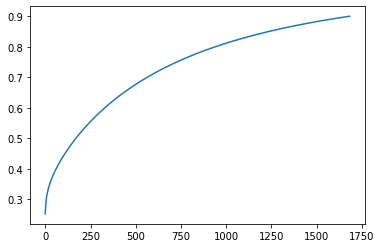

In [32]:
s = sv.volume(0.9).s
plt.plot(s.cumsum()/sv.s.sum())

In [ ]:
sparse.linalg.

In [57]:
from sklearn.preprocessing import normalize
sp_n = normalize(sp, axis=0)

In [61]:
word_corr = (sp_n.T @ sp_n)

In [65]:
wc = pd.DataFrame(word_corr.todense(),index = list(corpus), columns = list(corpus))

In [129]:
wc['cnt'] = wc.index.map(corpus_count)

In [143]:
def keycnt(n,corpus_count=corpus_count):
    cc = pd.Series(corpus_count)
    if n < 0:
        return cc[cc <= -n].sort_values()
    elif n > 0:
        return cc[cc >= n].sort_values(ascending = False)

keycnt(100)

and             6850
to              6847
of              6843
the             6832
in              6813
a               6775
with            6759
for             6729
experience      6348
is              6343
or              6292
as              6158
on              5987
an              5877
work            5871
manager         5783
are             5694
s               5660
all             5655
management      5547
be              5510
skills          5405
team            5284
that            5282
years           5217
by              5049
will            4942
at              4914
our             4875
other           4744
                ... 
prescription     101
got              101
timeliness       101
stories          101
salaried         101
quotas           101
spaces           101
invest           101
atlanta          101
flsa             101
logs             101
stressful        101
valley           101
collecting       101
keyboard         101
provision        101
exists       

In [151]:
wc.T.head()

KeyboardInterrupt: 

In [134]:
wcr.T.shape

(33640, 2791)

In [ ]:
df['coordinator'].sort_values(ascending = False)

In [127]:
[wc.iloc[i,i] for i in range(1000)]

[0.0,
 1.0,
 1.0000000000000002,
 1.0,
 1.0,
 1.0,
 1.0000000000000007,
 1.0,
 1.0,
 1.0000000000000002,
 1.0,
 1.0,
 0.9999999999999968,
 1.0000000000000073,
 0.9999999999999998,
 1.0,
 1.0000000000000002,
 0.9999999999999998,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 1.0000000000000002,
 1.000000000000009,
 0.9999999999999993,
 0.9999999999999998,
 1.0,
 0.9999999999999999,
 0.9999999999999998,
 1.0000000000000007,
 0.9999999999999998,
 0.9999999999999998,
 1.0,
 1.0,
 0.9999999999999999,
 1.0,
 1.0,
 1.0000000000000002,
 1.0,
 1.0000000000000007,
 1.0,
 1.0000000000000133,
 0.9999999999999998,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000000000000002,
 1.0000000000000002,
 1.0,
 0.9999999999999998,
 1.0000000000000002,
 0.9999999999999998,
 1.0,
 1.0000000000000007,
 1.0,
 1.0,
 0.9999999999999998,
 1.0,
 1.0000000000000002,
 1.0,
 0.9999999999999999,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999999,
 1.0,
 0.9999999999999987,
 1.0,
 0.9999999999999997,
 1.0,
 1.0000000000000002,
 0.99

In [223]:
crp = manager['corpus'][1]
(corpus_dict[key] for key in crp)

<generator object <genexpr> at 0x1add207408>

In [147]:
%timeit [(manager['corpus'][1]).issuperset(w) for w in corpus]

412 ms ± 3.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
set.isdisjoint

In [ ]:
set.

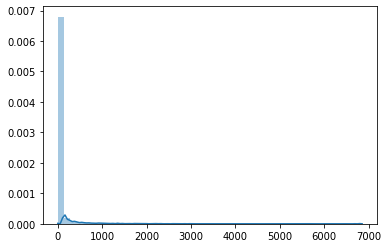

In [105]:
sns.distplot(list(corpus.values()))

In [74]:
stopw = set(stopwords.words('English'))
def is_not_stopw(lst):
    l = np.array(lst)
    return l[[item not in stopw for item in lst]]

def if_true(a,truth):
    if truth:
        return a

def remove_stopw(lst):
    return list(filter(is_not_stopw(lst),lst))

In [129]:
cnt = Counter()
aaa['parsed description keys'] = aaa['parsed description'].apply(lambda x:np.concatenate([key.replace(':','').split() for key in x.keys()]))
bbb = aaa['parsed description keys'].apply(lambda x: cnt.update(x))
var = pd.Series(cnt)
var = var[var > 20]
col = set(var.index)- {'000'} - stopw - {'&', '-','/'}
aaa['cnt keys']=pd.DataFrame(aaa['parsed description keys'].apply(lambda x: Counter(set(x).intersection(col))))
keyw_map = aaa['cnt keys'].apply(pd.Series)


In [144]:
from scipy.sparse import coo_matrix
eee = coo_matrix(keyw_map)
fff = eee.T @ eee

In [111]:
top_keys = keyw_map.apply(sum).sort_values(ascending = False)[:20].index

In [128]:
from sklearn.cluster import SpectralClustering
X = keyw_adj
clustering = SpectralClustering(n_clusters=2,       assign_labels="discretize",      random_state=0).fit(X)

/Users/davidnordfors/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/Users/davidnordfors/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [127]:
key_assoc = keyw_adj[top_keys].apply(norm_dot,axis = 0).T
key_assoc.loc['education'].sort_values(ascending = False)

education           0.579085
experience          0.448473
responsibilities    0.298211
skills              0.218457
duties              0.190717
job                 0.189561
requirements        0.168755
essential           0.165288
summary             0.151417
required            0.142171
qualifications      0.128300
physical            0.124833
work                0.113274
abilities           0.112118
position            0.110962
knowledge,          0.094780
knowledge           0.069352
demands             0.064728
minimum             0.064728
skills,             0.063572
functions           0.062416
and/or              0.061261
environment         0.061261
preferred           0.054325
primary             0.050858
following           0.046234
benefits            0.043923
general             0.042767
overview            0.040455
additional          0.040455
                      ...   
come                0.000000
previous            0.000000
range               0.000000
specifically, 

In [61]:
qqq = set(col.index)
%time set(aaa['cnt keys'][0]).intersection(qqq)

CPU times: user 118 µs, sys: 0 ns, total: 118 µs
Wall time: 123 µs


{'000', 'duties', 'position', 'requirements'}

In [38]:
aaa['cnt keys'][:5].apply(pd.Series)

000  position  duties  requirements  summary   of  qualifications  \
0  1.0       1.0     1.0           1.0      NaN  NaN             NaN   
1  1.0       1.0     NaN           NaN      1.0  1.0             1.0   
2  1.0       1.0     NaN           NaN      1.0  2.0             1.0   
3  1.0       NaN     NaN           NaN      NaN  NaN             NaN   
4  1.0       1.0     1.0           NaN      NaN  1.0             2.0   

   knowledge  and  experience  ...  well  strategic  communications  career  \
0        NaN  NaN         NaN  ...   NaN        NaN             NaN     NaN   
1        1.0  1.0         1.0  ...   NaN        NaN             NaN     NaN   
2        1.0  1.0         1.0  ...   NaN        NaN             NaN     NaN   
3        NaN  NaN         NaN  ...   NaN        NaN             NaN     NaN   
4        NaN  4.0         2.0  ...   1.0        1.0             1.0     1.0   

   field  management  basic  preferred  company  information  
0    NaN         NaN    NaN        NaN      NaN          NaN  
1    NaN         NaN    NaN        NaN      NaN          NaN  
2    NaN         NaN    NaN        NaN      NaN          NaN  
3    NaN         NaN    NaN        NaN      NaN          NaN  
4    1.0         1.0    1.0        1.0      1.0          1.0  

[5 rows x 108 columns]

In [507]:
def split(string):
    return string.split()

keys = pd.DataFrame(cnt.most_common())
keys[2] = keys[0].apply(split)

keys2 = keys[keys[1]!=1].copy()

#cnt = Counter([key.replace(':','') for key in np.concatenate(keys2[2].values)])

In [483]:
valid = lzdic.index.map(lambda x: not ('<>' in x[2:]))
lzdic[valid].sort_values(ascending = False)

 and                                         850
 the                                         570
 to                                          488
 of                                          458
 you                                         266
 in                                          250
 a                                           237
 for                                         208
 will                                        154
 we                                          147
 is                                          141
 with                                        141
 manager                                     135
 responsibilities                            133
 are                                         127
 our                                         127
 <>the                                       125
 the following                               122
 this                                        113
 be                                          103
 skills             

In [162]:
lst = []
zzz = aaa['clean description'].apply(lambda x: lst.extend(x.split()) )

In [164]:
zzz = lz_dic(lst)

In [206]:
lll = zzz.most_common()


In [358]:
bbb = ' '.join(aaa['clean description'][:2000].values)

In [359]:
%time ccc = lz_dic(bbb.split())

CPU times: user 1.69 s, sys: 56 ms, total: 1.74 s
Wall time: 1.79 s


In [361]:
ddd = pd.Series(ccc).reset_index()
ddd['n words'] = ddd['index'].apply(lambda x:x.split()).apply(len) 
eee = ddd[ddd['n words']!=1].sort_values(by = 0, ascending = False)


index     0  n words
823                           ability to  1229        2
617                               of the  1196        2
610                               in the  1050        2
11480                    account manager   686        2
347                                 in a   683        2
822                             with the   638        2
272                               to the   634        2
5003                              and or   542        2
555                         knowledge of   515        2
701                               we are   505        2
3167                                is a   502        2
24                               to work   456        2
1010                             for the   452        2
3259                           to ensure   437        2
1986                       experience in   425        2
1710                     responsible for   421        2
745                               with a   391        2
713                              will be   384        2
243                             you will   382        2
9407                         the account   379        2
535                             years of   375        2
565                              and the   368        2
305                                 as a   361        2
1852                           and other   348        2
842                                is an   342        2
5510                             well as   333        2
8108                  relationships with   333        2
834                             s degree   325        2
849                               on the   319        2
982                              as well   314        2
...                                  ...   ...      ...
4159                    maximizing their     4        2
126248               as a subject matter     4        4
114739         or preventable collisions     4        3
219849          more years of experience     4        4
20632                             to for     4        2
114755         different backgrounds and     4        3
227280   you will be responsible for the     4        6
93564                   available to all     4        3
20349                        san antonio     4        2
60908                    client problems     4        2
328974    understanding of the financial     4        4
247205                  a page diversity     4        3
20387                           the week     4        2
82304                            love of     4        2
60682                    ensuring timely     4        2
142658                         is not to     4        3
82582                     business lines     4        2
4753                  strategic projects     4        2
4566                   the establishment     4        2
114544                 professionals and     4        2
82585                        the lead in     4        3
79314                platforms including     4        2
92471                     experience two     4        2
54864                      businesses of     4        2
82819                 business preferred     4        2
82516                  expression sexual     4        2
54861                    life and health     4        3
320587                   for the monthly     4        3
19515                          to really     4        2
72834               retirement plan with     4        3

[26135 rows x 3 columns]

In [362]:
eee[eee[0] > 10]

index     0  n words
823                          ability to  1229        2
617                              of the  1196        2
610                              in the  1050        2
11480                   account manager   686        2
347                                in a   683        2
822                            with the   638        2
272                              to the   634        2
5003                             and or   542        2
555                        knowledge of   515        2
701                              we are   505        2
3167                               is a   502        2
24                              to work   456        2
1010                            for the   452        2
3259                          to ensure   437        2
1986                      experience in   425        2
1710                    responsible for   421        2
745                              with a   391        2
713                             will be   384        2
243                            you will   382        2
9407                        the account   379        2
535                            years of   375        2
565                             and the   368        2
305                                as a   361        2
1852                          and other   348        2
842                               is an   342        2
5510                            well as   333        2
8108                 relationships with   333        2
834                            s degree   325        2
849                              on the   319        2
982                             as well   314        2
...                                 ...   ...      ...
2772                  market conditions    11        2
3978                     the commercial    11        2
36225             relationships through    11        2
55827                 on customer needs    11        3
2721                        and through    11        2
125918                  equivalent work    11        2
38213                          input to    11        2
36593                     levels within    11        2
78412                       maintain an    11        2
81890                   the noise level    11        3
2716                        business by    11        2
38018                       degree in a    11        3
7908                    deadline driven    11        2
64845    both internally and externally    11        4
104180                       four years    11        2
36585                      starter with    11        2
35952                   competitive pay    11        2
35645                    customer value    11        2
5439     equal opportunity employer all    11        4
33741                         a history    11        2
54824                      the national    11        2
57030                pride ourselves on    11        3
66563                        goal is to    11        3
56633                     our corporate    11        2
129024                 minimum of three    11        3
7033                          and human    11        2
37739                projects including    11        2
57531               affiliate marketing    11        2
36548                   lead generation    11        2
2849                     microsoft word    11        2

[6241 rows x 3 columns]

In [278]:
kkk = pd.Series(Counter(zzz.values())).reset_index()


In [282]:
qqq = kkk.sort_values(by = 'index')

In [307]:
qq2.head()

index     0
150     11  2157
85      12  1683
155     13  1440
146     14  1272
60      15  1108

In [363]:
1+1

2

In [182]:
whole_db[1]

{'_id': ObjectId('5cbec831f85fd67fba2c8e42'),
 'JobId': '9c6fddeed43dd9e02e1c52cd9db7fdf8',
 'IsActive': True,
 'Model': {'Title': 'customer service representative',
  'Description': 'when our customers require assistance you ll make sure they get whatever they need to feel secure with schenectady savings loan you will greet all clients with a smiling face and an attitude that declares your eagerness to serve you ll answer the phones with a smile that can be heard on the other end you ll use your charm pleasant demeanor and can do attitude to offer banking the ssl way along the way you ll help our customers manage their accounts make deposits send money to friends and family and more schenectady savings loan offers industry leading benefits that include competitive salaries company provided healthcare roth ira and k paid time off tuition assistance management development courses customer service representative job responsibilities greet all guests as they enter your assigned branch ope

In [169]:
aaa = jd.titles(root = 'manager', title = 'account development manager', direction = 'shorter', max_items = 20000)
aaa.head()

ObjectId                time stamp  length  \
140  5cbeeb41f85fd67fba429722 2019-04-23 10:38:57+00:00    7409   
141  5cde7424ad09d295725f0a10 2019-05-17 08:43:16+00:00    1172   
142  5ce8ffe6ad09d29572bfd796 2019-05-25 08:42:14+00:00    1172   
143  5d4bdf6bad09d2957205bb1e 2019-08-08 08:38:03+00:00    2244   
144  5d4e7f54ad09d29572673af6 2019-08-10 08:24:52+00:00    2062   

                           title                     company  \
140  account development manager        PPG Industries, Inc.   
141  account development manager  Southeastern Freight Lines   
142  account development manager  Southeastern Freight Lines   
143  account development manager            Johnson Brothers   
144  account development manager                   Honeywell   

                                           description  \
140  PPG: WE PROTECT AND BEAUTIFY THE WORLD \n  \nA...   
141  Overview\n  \nResponsible for increasing reven...   
142  Overview\n  \nResponsible for increasing reven...   
143  What are we looking for?\n  \nWe are searching...   
144  Deliver business value through Right and Fast ...   

                                     clean description  \
140  ppg we protect and beautify the world at ppg n...   
141  overview responsible for increasing revenue an...   
142  overview responsible for increasing revenue an...   
143  what are we looking for we are searching high ...   
144  deliver business value through right and fast ...   

                                    parsed description  \
140  {'000': ['ppg: we protect and beautify the wor...   
141  {'000': ['overview', 'responsible for increasi...   
142  {'000': ['overview', 'responsible for increasi...   
143  {'000': ['what are we looking for?', 'we are s...   
144  {'000': ['deliver business value through right...   

                                                corpus  \
140  {retaining, reduce, objections, https, eo, tra...   
141  {or, accounts, perks, a, there, function, clos...   
142  {or, accounts, perks, a, there, function, clos...   
143  {top, accounts, integrity, generous, one, a, t...   
144  {different, siop, trade, landscape, they, plan...   

                           title set  
140  {manager, account, development}  
141  {manager, account, development}  
142  {manager, account, development}  
143  {manager, account, development}  
144  {manager, account, development}

In [181]:
aaa = jd.get('manager',max_items = 20000)
aaa.iloc[5]

ObjectId                                       5cbee212f85fd67fba3e1b0d
time stamp                                    2019-04-23 09:59:46+00:00
length                                                             4520
title                                        a c senior program manager
company                               Applied Research Associates, Inc.
description           Applied Research Associates (ARA), Inc. has a ...
clean description     applied research associates ara inc has a cont...
parsed description    {'000': ['applied research associates (ara), i...
corpus                {ara, problem, duties, collaborate, technology...
title set                              {manager, senior, program, c, a}
Name: 5, dtype: object

In [166]:
jd.titles(root = 'manager', title = 'account development manager', direction = 'longer', max_items = 20000)

ObjectId                time stamp  length  \
140   5cbeeb41f85fd67fba429722 2019-04-23 10:38:57+00:00    7409   
141   5cde7424ad09d295725f0a10 2019-05-17 08:43:16+00:00    1172   
142   5ce8ffe6ad09d29572bfd796 2019-05-25 08:42:14+00:00    1172   
143   5d4bdf6bad09d2957205bb1e 2019-08-08 08:38:03+00:00    2244   
144   5d4e7f54ad09d29572673af6 2019-08-10 08:24:52+00:00    2062   
145   5d64ecccad09d29572313b9b 2019-08-27 08:41:48+00:00    1809   
146   5d6a32d1ad09d29572fa9d91 2019-08-31 08:41:53+00:00    4619   
147   5d6b806cad09d29572223aa6 2019-09-01 08:25:16+00:00    3465   
148   5d8c8179ad09d295727374be 2019-09-26 09:14:33+00:00    1290   
149   5d946a59ad09d29572666b44 2019-10-02 09:14:01+00:00    3529   
150   5d99b13cad09d295723ab13d 2019-10-06 09:17:48+00:00    2403   
151   5d9ef89bad09d29572d8a72e 2019-10-10 09:23:39+00:00    2654   
152   5d9ef8d3ad09d29572d8e7b7 2019-10-10 09:24:35+00:00    2501   
153   5d79ffecad09d2957217ae2b 2019-09-12 08:21:00+00:00    5576   
154   5d8dd34fad09d29572a364c0 2019-09-27 09:15:59+00:00    3476   
155   5d6a325dad09d29572fa1fc1 2019-08-31 08:39:57+00:00    1893   
156   5d9ef83aad09d29572d8273c 2019-10-10 09:22:02+00:00    1760   
157   5d132bdbad09d295724fba50 2019-06-26 08:24:59+00:00    5402   
158   5cf8cca7ad09d29572d6ff07 2019-06-06 08:19:51+00:00    1781   
823   5d7ca70aad09d2957295ec1a 2019-09-14 08:38:34+00:00    4773   
907   5d775f26ad09d29572b0d3ae 2019-09-10 08:30:30+00:00    2318   
908   5cde7313ad09d295725e701e 2019-05-17 08:38:43+00:00    4736   
909   5d9ef787ad09d29572d77ca8 2019-10-10 09:19:03+00:00    4521   
947   5cbee206f85fd67fba3e1136 2019-04-23 09:59:34+00:00    4913   
948   5d4e7e25ad09d2957266d836 2019-08-10 08:19:49+00:00    4020   
971   5d4fd3d8ad09d29572927177 2019-08-11 08:37:44+00:00    6251   
972   5d9318a0ad09d29572381819 2019-10-01 09:13:04+00:00    2739   
1016  5d1db704ad09d29572cc69b9 2019-07-04 08:21:24+00:00    2552   
1017  5d1db6cbad09d29572cc4d29 2019-07-04 08:20:27+00:00    2366   
1112  5cbeedc2f85fd67fba45bbd9 2019-04-23 10:49:38+00:00    2833   
1365  5d9da381ad09d29572a543b7 2019-10-09 09:08:17+00:00    3369   
1366  5d9da6ddad09d29572a6f93b 2019-10-09 09:22:37+00:00    1762   
1450  5d9da7d7ad09d29572a7a23d 2019-10-09 09:26:47+00:00     984   
1469  5d99b181ad09d295723af768 2019-10-06 09:18:57+00:00    2970   

                                                  title  \
140                         account development manager   
141                         account development manager   
142                         account development manager   
143                         account development manager   
144                         account development manager   
145                         account development manager   
146                         account development manager   
147                         account development manager   
148                         account development manager   
149                         account development manager   
150                         account development manager   
151                         account development manager   
152                         account development manager   
153                  account development manager geiger   
154               account development manager sales rep   
155         account development manager sensors and iot   
156   account development manager sensors and iot mi...   
157   account development manager south division pas...   
158         account development manager territory sales   
823   account manager account development specialist...   
907                account manager business development   
908        account manager business development manager   
909        account manager business development manager   
947                  account manager client development   
948                  account manager client development   
971               account manager community development   
972   account manager community liaison business

In [165]:
aaa

ObjectId                time stamp  length  \
140  5cbeeb41f85fd67fba429722 2019-04-23 10:38:57+00:00    7409   
141  5cde7424ad09d295725f0a10 2019-05-17 08:43:16+00:00    1172   
142  5ce8ffe6ad09d29572bfd796 2019-05-25 08:42:14+00:00    1172   
143  5d4bdf6bad09d2957205bb1e 2019-08-08 08:38:03+00:00    2244   
144  5d4e7f54ad09d29572673af6 2019-08-10 08:24:52+00:00    2062   
145  5d64ecccad09d29572313b9b 2019-08-27 08:41:48+00:00    1809   
146  5d6a32d1ad09d29572fa9d91 2019-08-31 08:41:53+00:00    4619   
147  5d6b806cad09d29572223aa6 2019-09-01 08:25:16+00:00    3465   
148  5d8c8179ad09d295727374be 2019-09-26 09:14:33+00:00    1290   
149  5d946a59ad09d29572666b44 2019-10-02 09:14:01+00:00    3529   
150  5d99b13cad09d295723ab13d 2019-10-06 09:17:48+00:00    2403   
151  5d9ef89bad09d29572d8a72e 2019-10-10 09:23:39+00:00    2654   
152  5d9ef8d3ad09d29572d8e7b7 2019-10-10 09:24:35+00:00    2501   
176  5cbec840f85fd67fba2c9929 2019-04-23 08:09:36+00:00    3278   
177  5cbec84bf85fd67fba2ca10d 2019-04-23 08:09:47+00:00    1220   
178  5cbec85ef85fd67fba2cb9c3 2019-04-23 08:10:06+00:00    2935   
179  5cbece19f85fd67fba2f0749 2019-04-23 08:34:33+00:00    2619   
180  5cbed047f85fd67fba3047ac 2019-04-23 08:43:51+00:00    1842   
181  5cbed371f85fd67fba32a93f 2019-04-23 08:57:21+00:00    7782   
182  5cbed42df85fd67fba336eb4 2019-04-23 09:00:29+00:00    2982   
183  5cbed5bbf85fd67fba34e29e 2019-04-23 09:07:07+00:00    3472   
184  5cbed72df85fd67fba3615f9 2019-04-23 09:13:17+00:00    6869   
185  5cbed7d2f85fd67fba36b065 2019-04-23 09:16:02+00:00    3206   
186  5cbedbb0f85fd67fba37a583 2019-04-23 09:32:32+00:00    1745   
187  5cbedbb5f85fd67fba37ade1 2019-04-23 09:32:37+00:00    3533   
188  5cbedcaef85fd67fba38a741 2019-04-23 09:36:46+00:00    1204   
189  5cbedccef85fd67fba38cc7d 2019-04-23 09:37:18+00:00    2110   
190  5cbedd67f85fd67fba39583f 2019-04-23 09:39:51+00:00    4177   
191  5cbeddb3f85fd67fba399754 2019-04-23 09:41:07+00:00    4155   
192  5cbedebcf85fd67fba3aada4 2019-04-23 09:45:32+00:00    2247   
..                        ...                       ...     ...   
792  5d9ef805ad09d29572d7e1fa 2019-10-10 09:21:09+00:00    4310   
793  5d9ef81dad09d29572d7fc14 2019-10-10 09:21:33+00:00    6931   
794  5d9ef83dad09d29572d8336c 2019-10-10 09:22:05+00:00    3815   
795  5d9ef859ad09d29572d852ae 2019-10-10 09:22:33+00:00    5750   
796  5d9ef862ad09d29572d86db1 2019-10-10 09:22:42+00:00    6388   
797  5d9ef876ad09d29572d879c0 2019-10-10 09:23:02+00:00    2233   
798  5d9ef877ad09d29572d87ea2 2019-10-10 09:23:03+00:00    3047   
799  5d9ef879ad09d29572d883f6 2019-10-10 09:23:05+00:00    1797   
800  5d9ef880ad09d29572d895e4 2019-10-10 09:23:12+00:00    4446   
801  5d9ef8b2ad09d29572d8b5ce 2019-10-10 09:24:02+00:00    3910   
802  5d9ef8b3ad09d29572d8bd26 2019-10-10 09:24:03+00:00    3437   
803  5d9ef8b9ad09d29572d8cc61 2019-10-10 09:24:09+00:00    2602   
804  5da043bead09d29572082b0f 2019-10-11 08:56:30+00:00    5284   
805  5da0477ead09d29572087928 2019-10-11 09:12:30+00:00    4011   
806  5da048d4ad09d2957208c220 2019-10-11 09:18:12+00:00    3344   
807  5da048d4ad09d2957208c2c6 2019-10-11 09:18:12+00:00    5783   
808  5da048e5ad09d2957208cf4a 2019-10-11 09:18:29+00:00    4178   
809  5da048e6ad09d2957208d366 2019-10-11 09:18:30+00:00    5809   
810  5da048efad09d2957208d959 2019-10-11 09:18:39+00:00    1139   
811  5da04901ad09d2957208e3be 2019-10-11 09:18:57+00:00    3065   
812  5da04904ad09d2957208ea11 2019-10-11 09:19:00+00:00    1355   
813  5da04909ad09d2957208eef6 2019-10-11 09:19:05+00:00    2400   
814  5da04927ad09d295720907ae 2019-10-11 09:19:35+00:00    2373   
815  5da0493dad09d2957209148a 2019-10-11 09:19:57+00:00    4020   
816  5da0493fad09d295720915c4 2019-10-11 09:19:59+00:00    2870   
817  5da0494dad09d295720929f0 2019-10-11 09:20:13+00:00    2621   
818  5da049a7ad09d29572096dc2 2019-10-11 09:21:43+00:00    2949   
819  5da049c1ad09d29572097898 2019-10-11 09:22:09+00:00    2444   
8

In [56]:
from gensim.corpora import Dictionary
ddd = Dictionary()
bbb = gensim.parsing.preprocess_string(aaa.iloc[0]['clean description'])
gensim.corpora.Dictionary(bbb)

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [88]:
bbb = aaa.iloc[0]['clean description']
cnt = Counter(bbb[0])
idx = 1
cnt.update(bbb[:(idx+1)])

In [77]:
%timeit idx + 1

27.6 ns ± 0.425 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [148]:


zzz = lz_dic(bbb.split()) 


 audit                 7
 department            2
 a                    11
 a location            2
 va                    2
 wall                  3
 einhorn               2
 chernitzer            2
 p                     3
 c                     2
 wec                  11
 is                    3
 your                 22
 to                   42
 join                  2
 our                   7
 team                  4
 an                    6
 opportunity           2
 to work               2
 at                   11
 wec is                3
 an opportunity        2
 for                  11
 you                  35
 in                    9
 the                  16
 drivers               2
 of                   11
 your career           5
                      ..
 skills drive          2
 to a                  2
 collaborative         2
 wall einhorn          2
 equal                 2
 employment            2
 opportunities eeo     2
 and applicants        2
 regard                2


In [147]:
pd.Series(zzz)

title title                     1
 audit                          7
 manager                        1
 department                     2
 a                             11
 a location                     2
 norfolk                        1
 va                             2
 wall                           3
 einhorn                        2
 chernitzer                     2
 p                              3
 c                              2
 wec                           11
 is                             3
 seeking                        1
 your                          22
 talent                         1
 to                            42
 join                           2
 our                            7
 team                           4
 an                             6
 opportunity                    2
 to work                        2
 at                            11
 wec is                         3
 an opportunity                 2
 for                           11
 you          

In [118]:
cnt.update('putte')
cnt

Counter({'o': 9,
         't': 11,
         'i': 9,
         'l': 7,
         'e': 19,
         ' ': 26,
         'a': 17,
         'u': 1,
         'd': 2,
         'm': 2,
         'n': 14,
         'g': 2,
         'r': 7,
         'p': 2,
         'c': 6,
         'f': 1,
         'k': 3,
         'v': 1,
         'w': 2,
         'h': 2,
         'z': 1,
         's': 2,
         'y': 1})

In [69]:

cnt.update(bbb[:])
cnt

SyntaxError: invalid syntax (<ipython-input-69-9bee4d8e4b08>, line 1)

In [17]:
%timeit bbb.split()

31.2 µs ± 349 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [20]:
Word2Vec

2

In [35]:

def listem(nn):
    return aaa['title'].apply(lambda x: ngrams(x,N = nn, string_form = 'words')).apply(lambda array: list(filter(lambda string: 'manager' in string, array)))

def countem():
    cnt = Counter()
    [cnt.update(np.concatenate(listem(i).values)) for i in range(2,7)]
    return cnt.most_common()



df_titles_all     = pd.DataFrame(countem(), columns = ['title','count'])
df_titles_manager = df_titles_all[df_titles_all['title'].apply(lambda titles: titles[-7:] == 'manager')]
df_titles         = df_titles_manager.copy()[df_titles_manager['count']>1]
df_titles['corpus'] = df_titles['title'].apply(lambda x: set(x.split()))
df_titles['corpus length'] = df_titles['corpus'].apply(len)


title  count  \
0                                       account manager   1224   
2                                     assistant manager    570   
3                                    accounting manager    291   
5                                       project manager    272   
7                                       general manager    199   
8                             assistant general manager    175   
9                                          area manager    155   
11                                      program manager    139   
12                                        sales manager    135   
13                                       branch manager    123   
14                            assistant project manager    120   
15                             assistant branch manager    113   
16                                        nurse manager    110   
18                                  development manager    101   
19                                   operations manager    101   
20                              assistant nurse manager    101   
21                                     property manager     88   
22                                   area sales manager     85   
23                                       office manager     80   
24                           assistant property manager     79   
25                                    marketing manager     66   
26                                      payable manager     66   
27                             accounts payable manager     66   
29                                     services manager     60   
30                                        asset manager     54   
31                                       senior manager     50   
32                                 front office manager     42   
33                                         case manager     41   
34                                    community manager     41   
35                       assistant front office manager     41   
...                                                 ...    ...   
2208                assistant personal training manager      2   
2224            marriott assistant front office manager      2   
2225             marriott business travel sales manager      2   
2226                ac marriott lounge beverage manager      2   
2228             account based marketing senior manager      2   
2283             accounts receivable and credit manager      2   
2298          advanced analytics media services manager      2   
2300         advanced teaming technical project manager      2   
2301         advertising, marketing & commerce, manager      2   
2310           aerospace engine parts planning, manager      2   
2313           business development / marketing manager      2   
2315                  product manager / program manager      2   
2320              aftermarket sales and service manager      2   
2332       aircraft carrier engineering program manager      2   
2336                  amazon business smb sales manager      2   
2343                business & strategy program manager      2   
2347                        apg site - practice manager      2   
2350         behavior analysis clinical program manager      2   
2375            based lending field examination manager      2   
2395          assistant controller - accounting manager      2   
2398                 director / business office manager      2   
2405                   assistant front of house manager      2   
2445         ac marriott assistant front office manager      2   
2446          ac marriott business travel sales manager      2   
2495  manufacturing business development / marketing...      2   
2496        aerospace product manager / program manager      2   
2515      marketing business & strategy program manager      2   
2521  applied behavior analysis clinical program man...      2   
2534      asset based lending field examination manager      2   
2549       executive dir

In [576]:
df_titles.sort_values(by = 'corpus length',ascending = False).head()

title  count  \
14742    it security operations center soc manager      2   
14526        end user controls euc testing manager      2   
14273  big data cloud enablement architect manager      2   
14276     big data cloud enablement senior manager      2   
14285    brnch sales and service assistant manager      2   

                                                  corpus  corpus length  
14742   {manager, soc, operations, center, it, security}              6  
14526       {end, manager, testing, euc, user, controls}              6  
14273  {manager, architect, data, enablement, big, cl...              6  
14276    {manager, data, enablement, big, cloud, senior}              6  
14285   {service, brnch, sales, manager, assistant, and}              6

In [581]:
df_titles[(df_titles['corpus'] - df_titles['corpus'].loc[14742]).apply(len) == 0].sort_values(by='corpus length',ascending = False)

title  count  \
14742  it security operations center soc manager      2   
14078     security operations center soc manager      2   
12810             it security operations manager      2   
12809              operations center soc manager      2   
11838         security operations center manager      2   
1494                 security operations manager      8   
10277                         center soc manager      2   
7273                 operations security manager      2   
4966                   operations center manager      3   
1335                         it security manager      9   
612                    center operations manager     18   
492                        it operations manager     22   
33                                center manager    289   
6792                                 soc manager      2   
63                              security manager    155   
53                                    it manager    182   
9                             operations manager    900   
601                              manager manager     18   

                                                 corpus  corpus length  
14742  {manager, soc, operations, center, it, security}              6  
14078      {manager, soc, operations, center, security}              5  
12810               {security, it, manager, operations}              4  
12809                {soc, center, manager, operations}              4  
11838           {security, center, manager, operations}              4  
1494                    {security, manager, operations}              3  
10277                            {center, manager, soc}              3  
7273                    {security, manager, operations}              3  
4966                      {center, manager, operations}              3  
1335                            {security, it, manager}              3  
612                       {center, manager, operations}              3  
492                           {it, manager, operations}              3  
33                                    {center, manager}              2  
6792                                     {manager, soc}              2  
63                                  {security, manager}              2  
53                                        {it, manager}              2  
9                                 {manager, operations}              2  
601                                           {manager}              1

In [477]:

%time df_titles['counter'] = df_titles[0].apply(lambda x: Counter(x.split()))


CPU times: user 14.8 ms, sys: 1.6 ms, total: 16.4 ms
Wall time: 15.4 ms


In [510]:
%time df_titles['split'] = df_titles[0].apply(lambda x: x.split())

CPU times: user 3.78 ms, sys: 909 µs, total: 4.69 ms
Wall time: 4.66 ms


In [511]:
df_titles['pop']=df_titles['split']
df_titles.head(20)

0     1                 reverse  \
0                project manager  2412               [manager]   
1                account manager  2408               [manager]   
2                program manager  1345               [manager]   
3                general manager  1247               [manager]   
4                   case manager  1124               [manager]   
5                  sales manager  1110               [manager]   
6            development manager  1080               [manager]   
7              marketing manager  1018               [manager]   
8              assistant manager   985               [manager]   
9             operations manager   900               [manager]   
10  business development manager   735  [manager, development]   
11           engineering manager   727               [manager]   
12               product manager   682               [manager]   
13               service manager   588               [manager]   
14                branch manager   548               [manager]   
15                senior manager   534               [manager]   
16                 store manager   518               [manager]   
17              services manager   457               [manager]   
18               success manager   457               [manager]   
19            accounting manager   432               [manager]   

                                 pop                             split  
0                 [project, manager]                [project, manager]  
1                 [account, manager]                [account, manager]  
2                 [program, manager]                [program, manager]  
3                 [general, manager]                [general, manager]  
4                    [case, manager]                   [case, manager]  
5                   [sales, manager]                  [sales, manager]  
6             [development, manager]            [development, manager]  
7               [marketing, manager]              [marketing, manager]  
8               [assistant, manager]              [assistant, manager]  
9              [operations, manager]             [operations, manager]  
10  [business, development, manager]  [business, development, manager]  
11            [engineering, manager]            [engineering, manager]  
12                [product, manager]                [product, manager]  
13                [service, manager]                [service, manager]  
14                 [branch, manager]                 [branch, manager]  
15                 [senior, manager]                 [senior, manager]  
16                  [store, manager]                  [store, manager]  
17               [services, manager]               [services, manager]  
18                [success, manager]                [success, manager]  
19             [accounting, manager]             [accounting, manager]

In [512]:
Counter(df_titles['pop'].apply(lambda x: x.pop()))

Counter({'manager': 3713})

In [513]:
Counter(df_titles['pop'].apply(lambda x: x.pop()))

Counter({'project': 211,
         'account': 91,
         'program': 179,
         'general': 25,
         'case': 51,
         'sales': 98,
         'development': 34,
         'marketing': 70,
         'assistant': 39,
         'operations': 121,
         'engineering': 42,
         'product': 72,
         'service': 43,
         'branch': 12,
         'senior': 91,
         'store': 22,
         'services': 62,
         'success': 7,
         'accounting': 17,
         'finance': 18,
         'associate': 17,
         'resources': 2,
         'office': 13,
         'relationship': 38,
         'care': 24,
         'business': 22,
         'district': 8,
         'center': 21,
         'category': 12,
         'nurse': 18,
         'communications': 20,
         'compliance': 30,
         'area': 7,
         'construction': 11,
         'facilities': 10,
         'audit': 9,
         'brand': 9,
         'support': 24,
         'department': 12,
         'engagement': 15,
         'a

In [536]:
aaa.shape

(38183, 9)

In [532]:
bbb = aaa.copy()
ccc = bbb.groupby('company').agg(lambda x: list(x))

In [539]:
ccc['items'] = ccc['length'].apply(len)
ccc = ccc.sort_values(by='items',ascending = False)
ccc.head()

ObjectId  \
company                                                                       
Amazon.Com, Inc.          [5d3ffc7fad09d2957251ea2a, 5d5eefddad09d295728...   
Deloitte & Touche L.L.P.  [5d6f7267ad09d29572a757c3, 5d79fe6aad09d295721...   
Sodexo USA                [5d5e52daad09d2957262f989, 5d9075a5ad09d29572f...   
Facebook                  [5d907268ad09d29572f73e95, 5d970e9ead09d29572e...   
Marriott International    [5cf8ce50ad09d29572d75a0d, 5d68ddc5ad09d29572c...   

                                                                 time stamp  \
company                                                                       
Amazon.Com, Inc.          [2019-07-30 08:14:55+00:00, 2019-08-22 19:41:1...   
Deloitte & Touche L.L.P.  [2019-09-04 08:14:31+00:00, 2019-09-12 08:14:3...   
Sodexo USA                [2019-08-22 08:31:22+00:00, 2019-09-29 09:13:0...   
Facebook                  [2019-09-29 08:59:20+00:00, 2019-10-04 09:19:2...   
Marriott International    [2019-06-06 08:26:56+00:00, 2019-08-30 08:26:4...   

                                                                     length  \
company                                                                       
Amazon.Com, Inc.          [1731, 2010, 2380, 3072, 1749, 2033, 1410, 157...   
Deloitte & Touche L.L.P.  [7272, 8845, 9738, 7895, 8816, 8630, 6742, 898...   
Sodexo USA                [4099, 3068, 3359, 2497, 3519, 3738, 5950, 389...   
Facebook                  [3021, 2129, 1982, 3774, 2841, 3005, 1456, 353...   
Marriott International    [9425, 5097, 3504, 6848, 4207, 4630, 4485, 398...   

                                                                      title  \
company                                                                       
Amazon.Com, Inc.          [accessibility technical program manager, acco...   
Deloitte & Touche L.L.P.  [aai data science senior manager, account base...   
Sodexo USA                [area general manager, area general manager, a...   
Facebook                  [accessories technical program manager, accoun...   
Marriott International    [area manager performance improvement luxury b...   

                                                                description  \
company                                                                       
Amazon.Com, Inc.          [Amazon has a vast global operations workforce...   
Deloitte & Touche L.L.P.  [We help clients achieve competitive advantage...   
Sodexo USA                [Unit Description\n  \nBig things are happenin...   
Facebook                  [As an Accessory Technical Program Manager at ...   
Marriott International    [Marriott International is the world's largest...   

                                                          clean description  \
company                                                                       
Amazon.Com, Inc.          [amazon has a vast global operations workforce...   
Deloitte & Touche L.L.P.  [we help clients achieve competitive advantage...   
Sodexo USA                [unit description big things are happening wit...   
Facebook                  [as an accessory technical program manager at ...   
Marriott International    [marriott international is the world s largest...   

                                                         parsed description  \
company                                                                       
Amazon.Com, Inc.          [{'000': ['amazon has a vast global operations...   
Deloitte & Touche L.L.P.  [{'000': ['we help clients achieve competitive...   
Sodexo USA                [{'000': ['unit description', 'big things are ...   
Facebook                  [{'000': ['as an accessory technical program m...   
Marriott International    [{'000': ['marriott international is the world...   

                                                                     corpus  \
company                                                                       
Amazon.Com, Inc.          [{com

In [549]:
comp_dic = {}
def comp(name):
    df = pd.DataFrame(ccc.loc[name].to_dict()).sort_values(by = 'length', ascending = False)
    df['crpsim'] = crpsim_previous(df['corpus'])
    return df

In [550]:
comp('Amazon.Com, Inc.')

ObjectId                time stamp  length  \
497  5d5e4fabad09d2957261aad3 2019-08-22 08:17:47+00:00    6339   
21   5d8c7d5fad09d29572721932 2019-09-26 08:57:03+00:00    6174   
13   5cbecc1ef85fd67fba2df5da 2019-04-23 08:26:06+00:00    5474   
473  5d3ffc8fad09d2957251f63a 2019-07-30 08:15:11+00:00    5346   
301  5d8dce44ad09d29572a1fa40 2019-09-27 08:54:28+00:00    5177   
281  5d422dd0ad09d29572ac450f 2019-08-01 00:09:52+00:00    5159   
148  5d5e51b5ad09d29572627bd2 2019-08-22 08:26:29+00:00    4917   
317  5d907178ad09d29572f70d53 2019-09-29 08:55:20+00:00    4899   
147  5d8dce79ad09d29572a21a80 2019-09-27 08:55:21+00:00    4895   
139  5d9da176ad09d29572a50ed1 2019-10-09 08:59:34+00:00    4862   
63   5d5e4f6fad09d29572618b1f 2019-08-22 08:16:47+00:00    4746   
342  5d73696dad09d29572436aae 2019-09-07 08:25:17+00:00    4694   
72   5d95b7a6ad09d295729ebd83 2019-10-03 08:56:06+00:00    4679   
141  5d5e5179ad09d29572626d82 2019-08-22 08:25:29+00:00    4674   
247  5d74b8a7ad09d295726d6667 2019-09-08 08:15:35+00:00    4623   
341  5d5e52d8ad09d2957262f82b 2019-08-22 08:31:20+00:00    4621   
62   5cbee42ef85fd67fba406ee9 2019-04-23 10:08:46+00:00    4613   
457  5cbeca4df85fd67fba2d143c 2019-04-23 08:18:21+00:00    4608   
260  5d5e5208ad09d2957262b052 2019-08-22 08:27:52+00:00    4587   
150  5d5e5208ad09d2957262ae9e 2019-08-22 08:27:52+00:00    4483   
178  5d5e517ead09d29572626f85 2019-08-22 08:25:34+00:00    4459   
504  5d60fa55ad09d29572c02e10 2019-08-24 08:50:29+00:00    4446   
302  5d5e51f6ad09d29572629a1b 2019-08-22 08:27:34+00:00    4441   
205  5d5e52e6ad09d2957262fe8a 2019-08-22 08:31:34+00:00    4395   
117  5d5e5131ad09d2957262445e 2019-08-22 08:24:17+00:00    4281   
194  5d931487ad09d29572373bb1 2019-10-01 08:55:35+00:00    4251   
324  5d5e51f6ad09d29572629b71 2019-08-22 08:27:34+00:00    4228   
54   5d5e51a2ad09d29572627801 2019-08-22 08:26:10+00:00    4148   
153  5d5e5454ad09d29572638c16 2019-08-22 08:37:40+00:00    4116   
66   5d5e5203ad09d2957262a585 2019-08-22 08:27:47+00:00    4101   
..                        ...                       ...     ...   
472  5d5e4f33ad09d295726171f3 2019-08-22 08:15:47+00:00    1281   
352  5d8f1fd2ad09d29572ce5394 2019-09-28 08:54:42+00:00    1277   
280  5d60fa8bad09d29572c0545b 2019-08-24 08:51:23+00:00    1271   
405  5d9da60bad09d29572a640bf 2019-10-09 09:19:07+00:00    1264   
474  5d9da7afad09d29572a77b95 2019-10-09 09:26:07+00:00    1254   
401  5d907177ad09d29572f70af4 2019-09-29 08:55:19+00:00    1238   
398  5d946604ad09d29572657e50 2019-10-02 08:55:32+00:00    1231   
346  5d5e51dbad09d29572628840 2019-08-22 08:27:07+00:00    1219   
402  5d5e5226ad09d2957262c8cf 2019-08-22 08:28:22+00:00    1210   
266  5d5e548aad09d295726391eb 2019-08-22 08:38:34+00:00    1207   
193  5cbeca59f85fd67fba2d1c35 2019-04-23 08:18:33+00:00    1203   
432  5d5e5206ad09d2957262ad4a 2019-08-22 08:27:50+00:00    1201   
340  5d5e5163ad09d29572625a5e 2019-08-22 08:25:07+00:00    1195   
439  5d9da7cdad09d29572a79a1e 2019-10-09 09:26:37+00:00    1184   
285  5d5e4f0bad09d2957261650d 2019-08-22 08:15:07+00:00    1161   
333  5d5e51f9ad09d2957262a05e 2019-08-22 08:27:37+00:00    1155   
143  5d721676ad09d29572122ace 2019-09-06 08:19:02+00:00    1152   
395  5d132c2ead09d295724fdb25 2019-06-26 08:26:22+00:00    1141   
252  5d7366f3ad09d2957242e388 2019-09-07 08:14:43+00:00    1121   
286  5d5e53e6ad09d295726351fa 2019-08-22 08:35:50+00:00    1104   
364  5d62472ead09d29572eb673e 2019-08-25 08:30:38+00:00    1086   
251  5d5e505fad09d2957261e6c3 2019-08-22 08:20:47+00:00    1084   
396  5d5e516dad09d295726262b7 2019-08-22 08:25:17+00:00    1082   
253  5d970ed9ad09d29572e63142 2019-10-04 09:20:25+00:00    1066   
151  5d5e51f9ad09d29572629d50 2019-08-22 08:27:37+00:00    1065   
389  5d8b2b5dad09d2957242446c 2019-09-25 08:54:53+00:00    1061   
249  5d5e52f6ad09d295726309d4 2019-08-22 08:31:50+00:00    1047   
250  5d5e4f86ad09d295726192ef 2019-08-22 08:17:10+00:00    1031   
2

In [541]:
pd.DataFrame(ccc.iloc[0].to_dict()).sort_values(by='length')

ObjectId                time stamp  length  \
0    5d3ffc7fad09d2957251ea2a 2019-07-30 08:14:55+00:00    1731   
1    5d5eefddad09d2957288bced 2019-08-22 19:41:17+00:00    2010   
2    5d5eefcdad09d2957288b41d 2019-08-22 19:41:01+00:00    2380   
3    5d6790d8ad09d295727146c0 2019-08-29 08:46:16+00:00    3072   
4    5d5e5497ad09d29572639813 2019-08-22 08:38:47+00:00    1749   
5    5d57ba18ad09d2957290df20 2019-08-17 08:26:00+00:00    2033   
6    5d986145ad09d2957214d4f7 2019-10-05 09:24:21+00:00    1410   
7    5cbecfdff85fd67fba2ffc5c 2019-04-23 08:42:07+00:00    1576   
8    5d74bd8ead09d295726ef18b 2019-09-08 08:36:30+00:00    2426   
9    5d95b79dad09d295729eaf28 2019-10-03 08:55:57+00:00    1533   
10   5d5e51acad09d29572627a36 2019-08-22 08:26:20+00:00    2510   
11   5d985faaad09d2957213b7fd 2019-10-05 09:17:30+00:00    1540   
12   5d95b79dad09d295729eafdd 2019-10-03 08:55:57+00:00    1883   
13   5cbecc1ef85fd67fba2df5da 2019-04-23 08:26:06+00:00    5474   
14   5d73671ead09d295724303cd 2019-09-07 08:15:26+00:00    2071   
15   5d5e53f7ad09d29572635a17 2019-08-22 08:36:07+00:00    2333   
16   5d5e514fad09d29572624fdd 2019-08-22 08:24:47+00:00    3077   
17   5d5e505fad09d2957261e749 2019-08-22 08:20:47+00:00    2120   
18   5d00b922ad09d29572d41295 2019-06-12 08:34:42+00:00    2539   
19   5d5e5166ad09d29572625d30 2019-08-22 08:25:10+00:00    2503   
20   5d5e53faad09d29572635c4d 2019-08-22 08:36:10+00:00    3752   
21   5d8c7d5fad09d29572721932 2019-09-26 08:57:03+00:00    6174   
22   5d5e5203ad09d2957262a53a 2019-08-22 08:27:47+00:00    2242   
23   5d5e5091ad09d29572620508 2019-08-22 08:21:37+00:00    2669   
24   5d5e5325ad09d2957263253d 2019-08-22 08:32:37+00:00    2624   
25   5d8dce27ad09d29572a1f044 2019-09-27 08:53:59+00:00    3455   
26   5d5e5203ad09d2957262a701 2019-08-22 08:27:47+00:00    2175   
27   5cbee43bf85fd67fba4080d0 2019-04-23 10:08:59+00:00    2447   
28   5d9ef8b3ad09d29572d8b95c 2019-10-10 09:24:03+00:00    1863   
29   5d3ffc61ad09d2957251d838 2019-07-30 08:14:25+00:00    2217   
..                        ...                       ...     ...   
477  5d5e51a9ad09d295726279a3 2019-08-22 08:26:17+00:00    2621   
478  5d3ffc7ead09d2957251e813 2019-07-30 08:14:54+00:00    2570   
479  5d79fec4ad09d29572173cac 2019-09-12 08:16:04+00:00    2399   
480  5d79fe43ad09d29572170bdf 2019-09-12 08:13:55+00:00    2534   
481  5d5e51e5ad09d29572628cfb 2019-08-22 08:27:17+00:00    3258   
482  5d99b167ad09d295723ad532 2019-10-06 09:18:31+00:00    2261   
483  5d931454ad09d2957237212a 2019-10-01 08:54:44+00:00    2390   
484  5d4d2bebad09d29572369304 2019-08-09 08:16:43+00:00    2381   
485  5d9da79bad09d29572a76db3 2019-10-09 09:25:47+00:00    1920   
486  5d5e540dad09d29572636175 2019-08-22 08:36:29+00:00    2197   
487  5d5eefeaad09d2957288c381 2019-08-22 19:41:30+00:00    1287   
488  5d5e51fcad09d2957262a24a 2019-08-22 08:27:40+00:00    2201   
489  5d5e5235ad09d2957262cdac 2019-08-22 08:28:37+00:00    2427   
490  5d8b2b7bad09d295724255c7 2019-09-25 08:55:23+00:00    2345   
491  5d5e51acad09d29572627a6e 2019-08-22 08:26:20+00:00    2304   
492  5d639525ad09d295720dc886 2019-08-26 08:15:33+00:00    1458   
493  5d678f64ad09d29572707a6f 2019-08-29 08:40:04+00:00    2366   
494  5d5e4fb0ad09d2957261afee 2019-08-22 08:17:52+00:00    2333   
495  5d6b7e07ad09d2957221cd6b 2019-09-01 08:15:03+00:00    1912   
496  5d5e520fad09d2957262b23f 2019-08-22 08:27:59+00:00    2742   
497  5d5e4fabad09d2957261aad3 2019-08-22 08:17:47+00:00    6339   
498  5d5e53faad09d29572635cea 2019-08-22 08:36:10+00:00    2624   
499  5d6a3198ad09d29572f9ba47 2019-08-31 08:36:40+00:00    2604   
500  5d1723e2ad09d29572e4573b 2019-06-29 08:40:02+00:00    2817   
501  5d5e519fad09d295726276e4 2019-08-22 08:26:07+00:00    1577   
502  5d99b167ad09d295723adb50 2019-10-06 09:18:31+00:00    2857   
503  5d5eefd1ad09d2957288b77b 2019-08-22 19:41:05+00:00    1463   
504  5d60fa55ad09d29572c02e10 2019-08-24 08:50:29+00:00    4446   
5

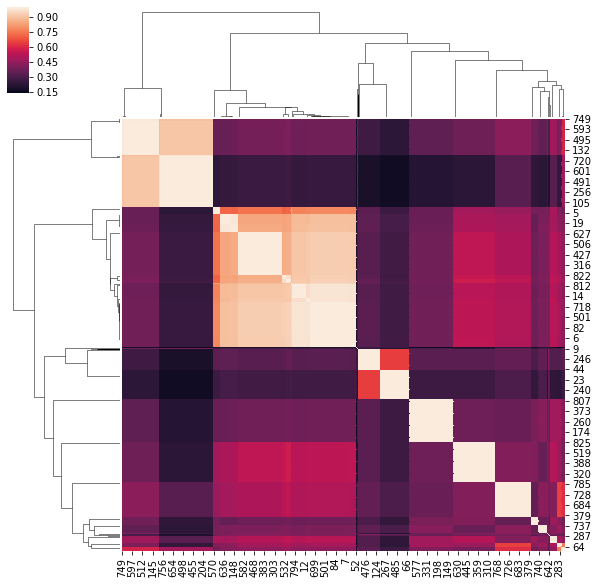

In [1054]:
sns.clustermap(sims)

In [950]:

%time aaa['character count'] = aaa['clean description'].apply(len)
%time aaa['wordsplit']       = aaa['clean description'].apply(lambda x: x.split())
%time aaa['word counts']     = aaa['wordsplit'].apply(Counter)
%time aaa['word count']      = aaa['wordsplit'].apply(len)
%time aaa['corpus']          = aaa['wordsplit'].apply(set)
# DEAD END - distribution too similar %time aaa['wordchar count']  = aaa['wordsplit'].apply(lambda x:list(map(len,x))).apply(Counter)
# SLOW 14.3ms %timeit aaa['character count 2'] = aaa['clean description'].apply(Counter)


CPU times: user 869 µs, sys: 44 µs, total: 913 µs
Wall time: 880 µs
CPU times: user 54.8 ms, sys: 5 ms, total: 59.8 ms
Wall time: 59.6 ms
CPU times: user 61.5 ms, sys: 1.67 ms, total: 63.2 ms
Wall time: 63.2 ms
CPU times: user 650 µs, sys: 34 µs, total: 684 µs
Wall time: 656 µs
CPU times: user 39.8 ms, sys: 3.2 ms, total: 43 ms
Wall time: 44.2 ms


In [853]:
def charray(counter,max_len = 20):
    return np.array([counter.get(i,0) for i in range(max_len)])

In [912]:
import scipy
from numpy import linalg as LA
from scipy.sparse import linalg as spLA
import scipy.sparse as sp
from sklearn.metrics.pairwise import cosine_similarity

def dot_norm(vec):
    return vec/LA.norm(vec)

In [793]:
corpus = aaa['corpus'] 
[1- (len(corpus[i].symmetric_difference(corpus[i+1]))/(len(corpus[i])+len(corpus[i+1]))) for i in range(len(corpus)-1)]

[0.20765027322404372,
 0.9748743718592965,
 0.9850746268656716,
 0.21911421911421913,
 0.27882960413080893,
 0.7839771101573677,
 0.24133811230585422,
 0.2875,
 0.23649635036496353,
 0.3164763458401305,
 0.2435129740518962,
 0.21731123388581952,
 0.3175074183976261,
 1.0,
 1.0,
 1.0,
 0.2666666666666667,
 0.23306233062330628,
 0.6159695817490494,
 0.37346437346437344,
 0.2204081632653061,
 0.21498371335504884,
 0.29811866859623737,
 0.2991452991452992,
 0.23563218390804597,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.39875389408099693,
 0.893523600439078,
 0.3358974358974359,
 0.2873239436619718,
 0.2464589235127479,
 0.2838018741633199,
 0.28214731585518105,
 0.34736842105263155,
 0.17228464419475653,
 1.0,
 0.35443037974683544,
 1.0,
 0.2527716186252772,
 1.0,
 0.21579961464354525,
 1.0,
 0.32930513595166166,
 0.9985815602836879,
 0.30068965517241375,
 0.5774877650897227,
 0.7446808510638299,
 0.27079934747145185,
 0.33333333333333337,
 0.22789783889980353,
 0.2205128205128205,
 0.2259740

In [773]:
aaa.sort_values(by='word count',ascending = False)

ObjecId                time stamp  \
18  5d721838ad09d29572129248 2019-09-06 08:26:32+00:00   
19  5d98612dad09d2957214cdb9 2019-10-05 09:23:57+00:00   
57  5d4fd448ad09d2957292c948 2019-08-11 08:39:36+00:00   
30  5d6f7267ad09d29572a757c3 2019-09-04 08:14:31+00:00   
25  5d020d0dad09d2957209a389 2019-06-13 08:45:01+00:00   
26  5d624712ad09d29572eb5d18 2019-08-25 08:30:10+00:00   
27  5d663849ad09d29572527747 2019-08-28 08:16:09+00:00   
28  5d68db05ad09d29572ca6803 2019-08-30 08:15:01+00:00   
29  5d6b7dfcad09d2957221c286 2019-09-01 08:14:52+00:00   
31  5d721586ad09d29572120013 2019-09-06 08:15:02+00:00   
7   5d985f45ad09d29572134160 2019-10-05 09:15:49+00:00   
69  5d4fd3c7ad09d2957292698b 2019-08-11 08:37:27+00:00   
32  5cd68618f0cccbbcab49cf30 2019-05-11 08:21:44+00:00   
33  5ce11128ad09d29572b7119c 2019-05-19 08:17:44+00:00   
62  5d8dd1c0ad09d29572a2c97a 2019-09-27 09:09:20+00:00   
79  5d4bde0fad09d29572050bee 2019-08-08 08:32:15+00:00   
66  5d721a68ad09d29572136502 2019-09-06 08:35:52+00:00   
67  5d721a1ead09d29572133279 2019-09-06 08:34:38+00:00   
37  5d34254cad09d29572ccf8ce 2019-07-21 08:41:48+00:00   
99  5d3815f0ad09d295724b90ce 2019-07-24 08:25:20+00:00   
98  5d3815edad09d295724b8944 2019-07-24 08:25:17+00:00   
22  5d99b100ad09d295723a7b00 2019-10-06 09:16:48+00:00   
68  5d9da6dbad09d29572a6f2cf 2019-10-09 09:22:35+00:00   
59  5d205ad1ad09d295722f6439 2019-07-06 08:24:49+00:00   
16  5d91c723ad09d29572178897 2019-09-30 09:13:07+00:00   
15  5d90736ead09d29572f76594 2019-09-29 09:03:42+00:00   
14  5d946a5aad09d29572666c19 2019-10-02 09:14:02+00:00   
13  5d931705ad09d2957237c5ef 2019-10-01 09:06:13+00:00   
70  5d6399e8ad09d295720e4c99 2019-08-26 08:35:52+00:00   
82  5d4bde4bad09d29572052741 2019-08-08 08:33:15+00:00   
..                       ...                       ...   
47  5d8b2e2bad09d29572432eb0 2019-09-25 09:06:51+00:00   
46  5d81d811ad09d29572282430 2019-09-18 07:09:05+00:00   
77  5d1721ccad09d29572e3a8bc 2019-06-29 08:31:08+00:00   
20  5d3ffea6ad09d29572527b5c 2019-07-30 08:24:06+00:00   
78  5cf78033ad09d29572a83f9f 2019-06-05 08:41:23+00:00   
12  5cbedc1ef85fd67fba381358 2019-04-23 09:34:22+00:00   
23  5cbee350f85fd67fba3f7498 2019-04-23 10:05:04+00:00   
64  5d8dce84ad09d29572a21ef5 2019-09-27 08:55:32+00:00   
56  5cbed4c6f85fd67fba33f5de 2019-04-23 09:03:02+00:00   
75  5d4bde13ad09d29572050cd7 2019-08-08 08:32:19+00:00   
11  5d4153c0ad09d2957283d041 2019-07-31 08:39:28+00:00   
42  5d32d2ffad09d295729e2a34 2019-07-20 08:38:23+00:00   
43  5d35757dad09d29572f46752 2019-07-22 08:36:13+00:00   
51  5d42a442ad09d29572b4d313 2019-08-01 08:35:14+00:00   
10  5cbee369f85fd67fba3f9048 2019-04-23 10:05:29+00:00   
4   5d946a9fad09d29572668d7a 2019-10-02 09:15:11+00:00   
52  5d7a0317ad09d2957218989d 2019-09-12 08:34:31+00:00   
45  5d8dd0cead09d29572a286c6 2019-09-27 09:05:18+00:00   
44  5d8c815bad09d29572735a44 2019-09-26 09:14:03+00:00   
17  5d60f41dad09d29572bd9d14 2019-08-24 08:23:57+00:00   
2   5d98605ead09d29572142bac 2019-10-05 09:20:30+00:00   
3   5d98610fad09d2957214b424 2019-10-05 09:23:27+00:00   
21  5d775da3ad09d29572b08dee 2019-09-10 08:24:03+00:00   
1   5d986054ad09d2957214178f 2019-10-05 09:20:20+00:00   
24  5cd7dac2f0cccbbcab9600c1 2019-05-12 08:35:14+00:00   
41  5d6b82d5ad09d2957222b4c8 2019-09-01 08:35:33+00:00   
40  5d6a32d5ad09d29572faa15f 2019-08-31 08:41:57+00:00   
61  5d8dce77ad09d29572a219ea 2019-09-27 08:55:19+00:00   
58  5d624986ad09d29572ec8153 2019-08-25 08:40:38+00:00   
55  5d9da611ad09d29572a65211 2019-10-09 09:19:13+00:00   

                                                title  \
18              a quality aircraft conformity manager   
19                          a quality control manager   
57                        academic operations manager   
30                    aai data science senior manager   
25                    aai data science senior manager   
26                    aai data science senior manager   
27                    aai

In [734]:
ddd = ccc[2]
type(ddd)

collections.Counter

In [735]:
ccc[1].subtract(ccc[2])

In [752]:
def counter_similarity(counter1,counter2):
    total = counter1+counter2
    diff = (counter1-counter2)+(counter2-counter1)
    return 1 - (sum(diff.values()) / sum(total.values()))
cntsim = counter_similarity

In [758]:

df = pd.DataFrame([[cntsim(item,item1) for item1 in ccc ] for item in ccc])

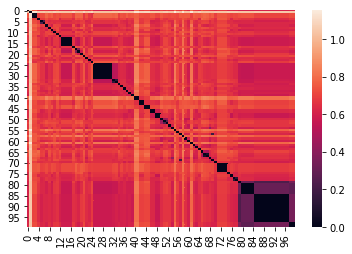

In [691]:
bbb = aaa.groupby('title').count().sort_values(by='company',ascending=False)

In [694]:
characters('hello')

NameError: name 'characters' is not defined

In [684]:
aaa.iloc[-1]

ObjecId                                        5d946a96ad09d295726684b6
time stamp                                    2019-10-02 09:15:02+00:00
title                                        clinical contracts manager
company                                              Bluebird Bio, Inc.
description           Manager  Clinical Contracts (1 Year Contract) ...
parsed description    {'000': ['Manager  Clinical Contracts (1 Year ...
Name: 39999, dtype: object

In [716]:
import itertools

In [695]:
cnt = Counter()

In [717]:
sss = list(aaa['parsed description'][1].values())
merged = list(itertools.chain(*sss))
merged

['Love direct care but want to utilize your supervisory skills and potential?',
 'Pathlight is looking for an experienced Direct Support Professional to step into a DSP 5 position in Springfield. This position parallels Supervisor and Assistant Manager Positions.',
 'Springfield - 41.25 hours',
 'Sunday 2:00p-10:15p',
 'Wednesday 2:00p-10:15p',
 'Thursday 2:00p-10:15p',
 'Friday 2:00p-10:15p',
 'Saturday 2:00p-10:15p',
 'Perform a variety of direct care duties to support and instruct individuals with developmental disabilities with unusually complex behavioral needs. Implement behavior plans, programs, assessments and analysis of data ensuring a high degree of reliability between the written plan and the observed behavior of staff working with individuals. Provide supportive services to assist and train staff in implementing plans for working with individuals with developmental disorders.',
 '220 Brookdale Drive, Springfield, MA 01104 Monday thru Friday, 9 am - 5 pm.',
 ' Minimum 18 ye

## Watson NLU

In [88]:
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

apikey,apiurl = '5wcQoq8p_gaRiikkIl8Y90fqtO2v5Mk_UvOQjXK38FYH','https://gateway.watsonplatform.net/natural-language-understanding/api'



authenticator = IAMAuthenticator(apikey)
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2019-07-12',
    authenticator=authenticator
)

natural_language_understanding.set_service_url(apiurl)

## TEST service:
# response = natural_language_understanding.analyze(
#     url='www.ibm.com',
#     features=Features(categories=CategoriesOptions(limit=3))).get_result()

# print(json.dumps(response, indent=2))

nlu = natural_language_understanding

features = Features(
                        categories= CategoriesOptions(),
                        concepts  = ConceptsOptions(),
                        entities  = EntitiesOptions(),
                        keywords  = KeywordsOptions(),
                        relations = RelationsOptions(),
                        syntax    = SyntaxOptions()
                        )

In [91]:
nlu_ibm = {}
nlu_ibm[0] = nlu.analyze(text = aaa['Model']['Description'] , features = features )

In [104]:
bbb = nlu_ibm[0].result
bbb.keys()

dict_keys(['usage', 'relations', 'language', 'keywords', 'entities', 'concepts', 'categories', 'warnings'])

In [ ]:
1+1